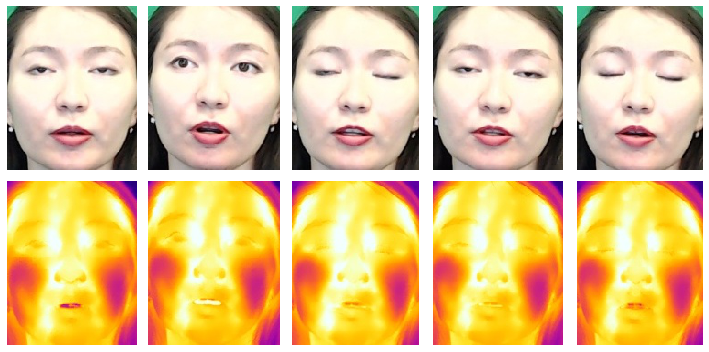

Text(0, 0.5, 'Amplitude')

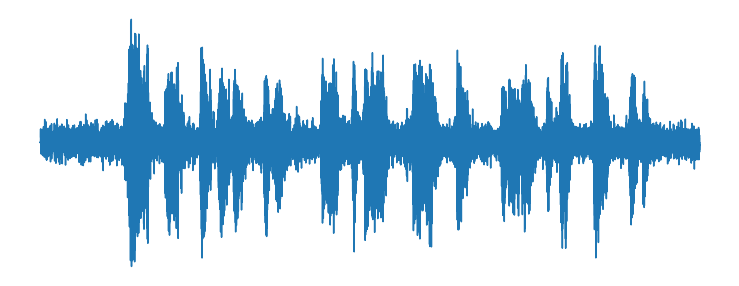

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import librosa
import librosa.display

rgb_video_dir = glob('Dataset/zhanat/preprocessed/session_1/rgb_roi/*')
thr_video_dir = glob('Dataset/zhanat/preprocessed/session_1/thr_roi/*')

rgb_frames = []
thr_frames = []

for i in range(len(rgb_video_dir)):
    rgb = mpimg.imread(rgb_video_dir[i])
    thr = mpimg.imread(thr_video_dir[i])
    
    rgb_frames.append(rgb)
    thr_frames.append(thr)

n = 5
d = len(rgb_video_dir)//(n+1)

fig, ax = plt.subplots(2, n, figsize=(10,5))

for i in range(2*n):
	if i < n:
		ax[0, i].axis('off')
		ax[0, i].imshow(rgb_frames[d*(i+1)])
	else:
		ax[1, i-n].axis('off')
		ax[1, i-n].imshow(thr_frames[d*(i+1-n)])
        
fig.tight_layout()
plt.show()

y, sr = librosa.load('Dataset/zhanat/preprocessed/session_1/audio.wav')
plt.figure(figsize=(13, 5))
plt.plot(y)
plt.axis('off')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

In [3]:
from scipy.io import wavfile
from pesq import pesq
from pystoi.stoi import stoi
from glob import glob
import os, librosa, sys, argparse
import numpy as np
from tqdm import tqdm
import speech_recognition as sprec
import jiwer
import pandas as pd

commands_csv = '/raid/madina_abdrakhmanova/datasets/SpeakingFacesLipReading/lip_reading/metadata/train_commands.csv'
commands_df = pd.read_csv(commands_csv, header=None)

sr = 16000

results_root = 'synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results'

all_files = glob("{}/wavs/*.wav".format(results_root))
gt_folder = results_root + '/gts/{}'

print('Calculating for {} files'.format(len(all_files)))

total_pesq = 0
total_stoi = 0
total_estoi = 0
total_wrr_gt = 0
total_wrr = 0

for filename in tqdm(all_files):
	session_num = os.path.basename(filename).split("_")[1]
	madina_folder = '/raid/madina_abdrakhmanova/datasets/SpeakingFacesLipReading/lip_reading/purified/'
	session_vid_dir = os.path.basename(glob(madina_folder + 'session_'+session_num+'/*_rgb.avi')[0])
	command_start = int(session_vid_dir.split("_")[0])
	command_end = int(session_vid_dir.split("_")[1])
    
	text_orig = ''
    
	for i in range(command_start, command_end+1):
		text_orig += " " + commands_df[1][i]
    
	gt_filename = gt_folder.format(os.path.basename(filename))
	rate, deg = wavfile.read(filename)
	rate, ref = wavfile.read(gt_filename)
	if len(ref.shape) > 1: ref = np.mean(ref, axis=1) #raise ValueError('Audio should be a mono band')

	if rate != sr:
		ref = librosa.resample(ref.astype(np.float32), rate, sr).astype(np.int16)
		deg = librosa.resample(deg.astype(np.float32), rate, sr).astype(np.int16)
		rate = sr

	if len(ref) > len(deg): x = ref[0 : deg.shape[0]]
	elif len(deg) > len(ref):
		deg = deg[: ref.shape[0]]
		x = ref
	else: x = ref

	total_pesq += pesq(rate, x, deg, 'nb')
	total_stoi += stoi(x, deg, rate, extended=False)
	total_estoi += stoi(x, deg, rate, extended=True)
    
	r = sprec.Recognizer()
	transformation = jiwer.Compose([jiwer.ToLowerCase(), jiwer.Strip(), jiwer.RemoveMultipleSpaces()])
	print (filename)
# 	with sprec.AudioFile(filename) as source:
# 		audio_data = r.record(source)
# 		text = r.recognize_google(audio_data)
# 		print('audio processed')
# 		wrr = 1-jiwer.wer(text_orig, text, truth_transform=transformation, hypothesis_transform=transformation)
# 		total_wrr += wrr
        
# 	print(text)
    
# 	with sprec.AudioFile(gt_filename) as gt_source:
# 		gt_audio_data = r.record(gt_source)
# 		text = r.recognize_google(gt_audio_data)
# 		gt_wrr = 1-jiwer.wer(text_orig, text, truth_transform=transformation, hypothesis_transform=transformation)
# 		total_wrr_gt += gt_wrr
        
# 	print(text)

print('Mean STOI: {}'.format(total_stoi / len(all_files)))
print('Mean ESTOI: {}'.format(total_estoi / len(all_files)))
print('Mean PESQ: {}'.format(total_pesq / len(all_files)))
print('Mean WRR_gt: {}'.format(total_wrr_gt / len(all_files)))
print('Mean WRR: {}'.format(total_wrr / len(all_files)))

  0%|                                                    | 0/32 [00:00<?, ?it/s]

Calculating for 32 files


  3%|█▍                                          | 1/32 [00:01<00:36,  1.18s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_413_thr_roi_0.03571428571428571:8.571428571428571.wav


  6%|██▊                                         | 2/32 [00:01<00:32,  1.07s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_309_thr_roi_0.03571428571428571:6.607142857142857.wav


  9%|████▏                                       | 3/32 [00:03<00:33,  1.16s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_455_thr_roi_0.03571428571428571:7.928571428571429.wav


 12%|█████▌                                      | 4/32 [00:04<00:30,  1.08s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_337_thr_roi_0.03571428571428571:7.321428571428571.wav


 16%|██████▉                                     | 5/32 [00:05<00:29,  1.09s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_464_thr_roi_0.03571428571428571:10.214285714285714.wav


 19%|████████▎                                   | 6/32 [00:06<00:32,  1.25s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_238_thr_roi_0.03571428571428571:13.642857142857142.wav


 22%|█████████▋                                  | 7/32 [00:08<00:30,  1.22s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_431_thr_roi_0.03571428571428571:9.892857142857142.wav


 25%|███████████                                 | 8/32 [00:09<00:29,  1.25s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_229_thr_roi_0.03571428571428571:11.178571428571429.wav


 28%|████████████▍                               | 9/32 [00:10<00:25,  1.10s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_555_thr_roi_0.03571428571428571:7.464285714285714.wav


 31%|█████████████▍                             | 10/32 [00:11<00:27,  1.23s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_82_thr_roi_0.03571428571428571:10.892857142857142.wav


 34%|██████████████▊                            | 11/32 [00:12<00:25,  1.20s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_544_thr_roi_0.03571428571428571:10.0.wav


 38%|████████████████▏                          | 12/32 [00:13<00:20,  1.05s/it]

synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/wavs/session_147_thr_roi_0.03571428571428571:5.642857142857143.wav


 38%|████████████████▏                          | 12/32 [00:14<00:24,  1.21s/it]


KeyboardInterrupt: 

In [12]:
filename = 'synthesizer/saved_models/logs-zhanat_thr_learningrate_50k20k/test_results/gts/session_147_thr_roi_0.03571428571428571:5.642857142857143.wav'

import pandas as pd
import speech_recognition as sr
from jiwer import wer
import jiwer

df = pd.read_csv('/raid/madina_abdrakhmanova/datasets/SpeakingFacesLipReading/lip_reading/metadata/train_commands.csv', header=None)
text_orig = df[1][211]+' '+df[1][212]
print(text_orig)
r = sr.Recognizer()

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.Strip(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
])

with sr.AudioFile(filename) as source:
    print('started')
    r.adjust_for_ambient_noise(source,duration=1)
    audio_data = r.record(source)
    print('recorded')
    text = r.recognize_google(audio_data)
    print(text)
#     error = wer(text_orig, 'comedy channels in youtube my calendar schedule', truth_transform=transformation, hypothesis_transform=transformation)
#     error = wer(text_orig, text)
#     print(1-error)

comedy channels in youtube my calendar schedule
started
recorded


KeyboardInterrupt: 